Learning to rank.


In [1]:
from wvpy.jtools import declare_task_variables

# set up for external override
with declare_task_variables(globals()):
    rand_seed = 2024
    do_display = True
    result_fname = ""

In [2]:
# set up Python
import logging
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import spearmanr
from cmdstanpy import CmdStanModel
from plotnine import *
from rank_plotting_fns import (
    define_Stan_choice_src,
    define_Stan_panel_src,
    define_Stan_reading_panel_src,
    estimate_model_from_scores,
    format_Stan_data,
    format_Stan_reading_data,
    mk_example,
    plot_rank_performance,
    run_stan_model,
    sort_observations_frame,
    XgboostClassifier,
)

# quiet down Stan
logger = logging.getLogger("cmdstanpy")
logger.addHandler(logging.NullHandler())

In [3]:
rng = np.random.default_rng(rand_seed)

In [4]:
example_name = "uci wine example"

In [5]:
if do_display:
    print(example_name)

uci wine example


In [6]:

# read data and set scale of system
features_frame = pd.read_csv("uci_wine_example_features.csv")
features_scores = pd.read_csv("uci_wine_example_scores.csv")
score_name = "quality"
# score_name = "linear_score"
m_train_examples: int = 100
m_test_examples: int = 100
noise_scale = 0.87
continue_reading_probability = 0.8

know_score: bool = True

In [7]:
features_frame.head()

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
features_frame.shape

(6497, 23)

In [9]:
collected_stats = []

In [10]:
n_alternatives: int = 5

In [11]:
n_vars = features_frame.shape[1] + n_alternatives

In [12]:


continue_reading_probability


0.8

In [13]:
observations_train = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_reading_probability=continue_reading_probability,
    n_alternatives=n_alternatives,
    m_examples=m_train_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [14]:
observations_test = mk_example(
    features_frame=features_frame,
    features_scores=features_scores,
    continue_reading_probability=continue_reading_probability,
    n_alternatives=n_alternatives,
    m_examples=m_test_examples,
    score_name=score_name,
    noise_scale=noise_scale,
    rng=rng,
)

In [15]:
perfect_coef = None
if know_score:
    perfect_coef = estimate_model_from_scores(
            observations=observations_train,
            features_frame=features_frame,
        )

In [16]:
# make sure we don't have a column we would not know in practice
observations_train = observations_train.loc[
    :, [c for c in observations_train.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)
observations_test = observations_test.loc[
    :, [c for c in observations_test.columns if not c.startswith("score_value_")]
].reset_index(drop=True, inplace=False)

observations_train.head()

,display_position_0,item_id_0,pick_value_0,display_position_1,item_id_1,pick_value_1,display_position_2,item_id_2,pick_value_2,display_position_3,item_id_3,pick_value_3,display_position_4,item_id_4,pick_value_4
0,0,1569,1,1,1754,0,2,6425,0,3,2780,0,4,2646,0
1,0,4390,0,1,2031,0,2,2692,1,3,4416,0,4,1913,0
2,0,599,1,1,1808,0,2,64,0,3,59,0,4,1671,0
3,0,1392,1,1,2324,0,2,5815,0,3,1819,0,4,4567,0
4,0,2063,0,1,6283,0,2,3610,0,3,2085,0,4,5610,1


In [17]:
win_frequencies = (
    observations_train
        .loc[
            :, 
            [c for c in observations_train.columns if c.startswith("pick_value_")]]
        .mean(axis=0)
        .reset_index(drop=False, inplace=False)
        .sort_values(['index'], ignore_index=True)
)
win_frequencies.columns = ['position', 'win frequency']

win_frequencies

,position,win frequency
0,pick_value_0,0.45
1,pick_value_1,0.24
2,pick_value_2,0.17
3,pick_value_3,0.09
4,pick_value_4,0.05


In [18]:
# TODO: better estimate here
p_continue_est = np.mean( 
    (np.array(win_frequencies['win frequency'][range(1, win_frequencies.shape[0])]) + 1e-2)
 / (np.array(win_frequencies['win frequency'][range(0, win_frequencies.shape[0] - 1)]) + 1e-2)
)

p_continue_est

0.6047584541062802

In [19]:
# This is the observable data
observations_train[
    [c for c in observations_train.columns if not c.startswith("display_position_")]
].head(10)

,item_id_0,pick_value_0,item_id_1,pick_value_1,item_id_2,pick_value_2,item_id_3,pick_value_3,item_id_4,pick_value_4
0,1569,1,1754,0,6425,0,2780,0,2646,0
1,4390,0,2031,0,2692,1,4416,0,1913,0
2,599,1,1808,0,64,0,59,0,1671,0
3,1392,1,2324,0,5815,0,1819,0,4567,0
4,2063,0,6283,0,3610,0,2085,0,5610,1
5,2010,1,1465,0,6388,0,25,0,420,0
6,5903,0,1374,0,312,0,926,1,5467,0
7,5194,1,3651,0,1494,0,1749,0,5865,0
8,5946,1,4527,0,5988,0,3021,0,4821,0
9,6469,1,6044,0,2787,0,5786,0,3709,0


In [20]:
score_compare_frame = pd.DataFrame([[] for i in range(features_frame.shape[0])])
if know_score:
    score_compare_frame["hidden concept"] = features_scores[
        score_name
    ]  # would not know this for non-synthetic data

Try a Stan model.


In [21]:
stan_model_reading_panel_src = define_Stan_reading_panel_src(n_alternatives=n_alternatives)
if do_display:
    print(stan_model_reading_panel_src)
data_reading_str = format_Stan_reading_data(
    observations=observations_train,
    features_frame=features_frame,
    p_continue=p_continue_est,
)
fit = run_stan_model(
    stan_model_src=stan_model_reading_panel_src,
    data_str=data_reading_str,
)


data {
  int<lower=1> n_vars;                              // number of variables per alternative
  int<lower=1> m_examples;                          // number of examples
  real<lower=0, upper=1> p_continue;                // modeled probability of reading on
  array[m_examples] int<lower=1, upper=5> picked_index;   // which position was picked
  matrix[m_examples, n_vars] x_1;                   // features examples
  matrix[m_examples, n_vars] x_2;                   // features examples
  matrix[m_examples, n_vars] x_3;                   // features examples
  matrix[m_examples, n_vars] x_4;                   // features examples
  matrix[m_examples, n_vars] x_5;                   // features examples
}
parameters {
  vector[n_vars] beta;                              // model parameters
  vector[m_examples] error_picked;                  // reified noise term on picks
}
transformed parameters {
  array[5] vector[m_examples] expected_value;             // modeled expected score of it

In [22]:
# get implied sample weights from chain
wt_frame = fit.draws_pd(vars=["lp__"])

wt_frame

,lp__
0,-122.633
1,-127.784
2,-138.966
3,-130.346
4,-123.764
...,...
3995,-135.702
3996,-120.718
3997,-127.295
3998,-136.383


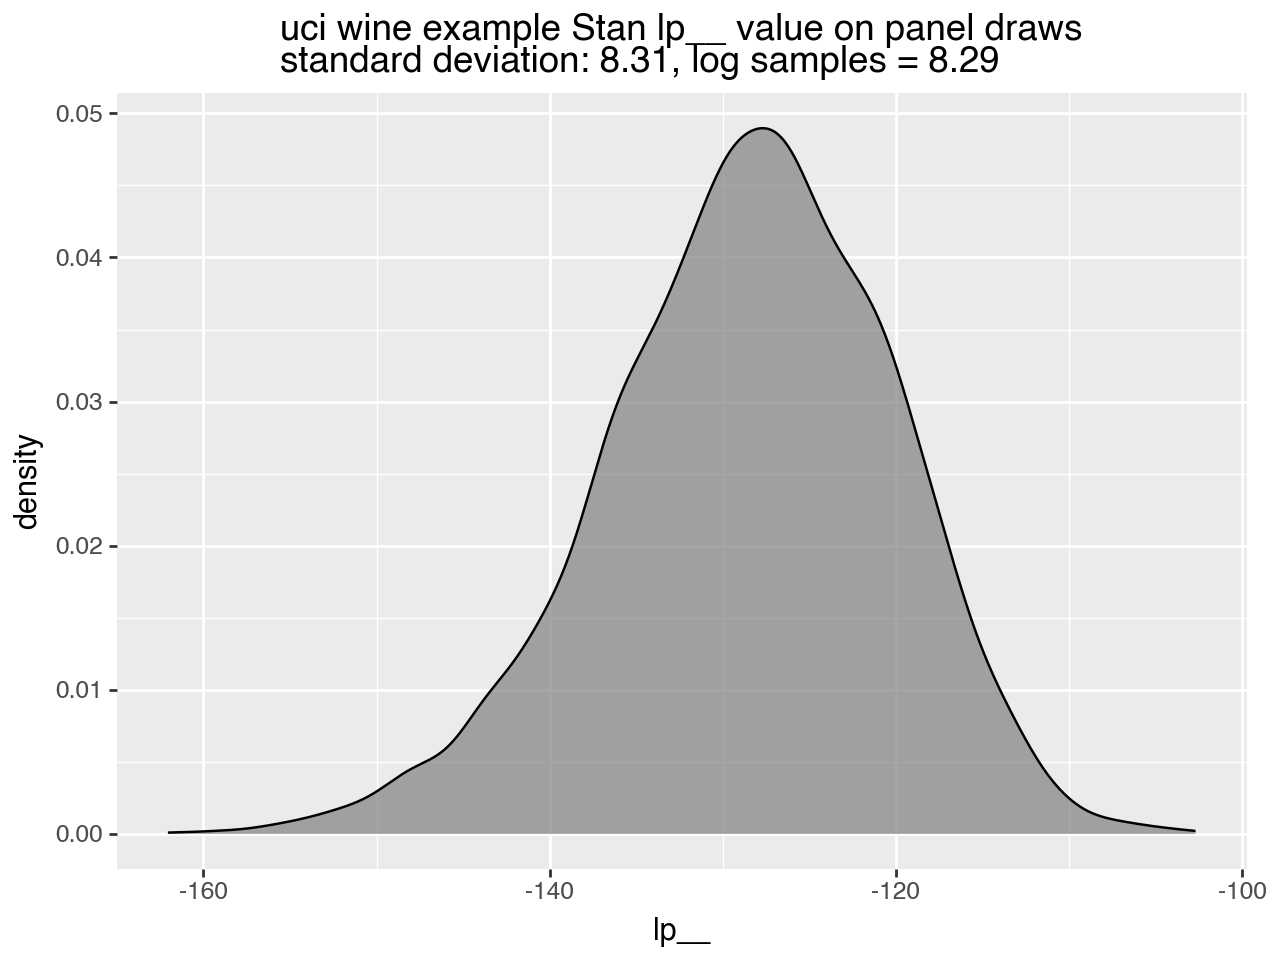

In [23]:
if do_display:
    stddev = np.sqrt(np.var(wt_frame["lp__"]))
    log_samples = np.log(wt_frame.shape[0])
    (
        ggplot(
            data=wt_frame,
            mapping=aes(x="lp__"),
        )
        + geom_density(fill="gray", alpha=0.7)
        + ggtitle(
            f"{example_name} Stan lp__ value on panel draws\nstandard deviation: {stddev:.2f}, log samples = {log_samples:.2f}"
        )
    ).show()

In [24]:
beta_draws = fit.draws_pd(vars=["beta"])
beta_draws_display = beta_draws.copy()
beta_draws_display.columns = list(features_frame.columns) 

beta_draws_display

,fixed acidity is red,volatile acidity is red,citric acid is red,residual sugar is red,chlorides is red,free sulfur dioxide is red,total sulfur dioxide is red,density is red,pH is red,sulphates is red,...,citric acid is white,residual sugar is white,chlorides is white,free sulfur dioxide is white,total sulfur dioxide is white,density is white,pH is white,sulphates is white,alcohol is white,is_red
0,-1.447790,-4.62478,-9.358130,-0.969888,-3.805040,0.657024,-0.826429,-12.26870,6.69478,-14.581700,...,-21.050900,1.203160,10.82310,-0.085206,-0.008877,-15.294100,-0.099358,5.26971,5.71451,3.631910
1,1.982870,5.42523,0.756518,-4.045890,0.692858,0.586712,-0.406622,8.52986,4.42748,-0.465490,...,18.700900,0.054998,-19.08290,0.044433,0.000917,8.355370,2.921380,-5.73260,3.01479,0.967835
2,-2.801820,-15.20920,2.075350,4.500070,-0.516122,1.870690,-0.776236,-8.50217,5.86090,-0.836496,...,-24.964600,1.083870,22.09530,0.110386,-0.160666,-9.987080,6.760540,21.84320,6.74097,0.383325
3,1.956690,7.10941,-2.158170,-5.820560,-4.182180,0.977018,-1.250920,13.14720,5.21992,-1.288310,...,19.242200,0.477058,-15.26130,-0.142394,0.035290,3.632720,0.583129,1.60919,2.65061,0.379905
4,-3.039510,-14.74660,-0.632361,6.667690,-5.598030,1.045840,-0.542295,1.09455,-1.53817,0.177160,...,-21.738100,0.650416,15.34560,0.150917,-0.196663,-6.836360,0.200967,12.84900,5.89867,0.534335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1.058210,-5.11626,-12.431600,2.473300,0.723276,0.503297,-0.198909,-3.82946,9.06861,-8.002290,...,2.666200,1.100960,-2.18976,0.050539,-0.008043,-1.142650,14.817900,5.60322,6.13048,-6.501290
3996,0.055496,1.27209,6.389810,-0.634675,-7.401740,0.532500,-0.515655,-10.68020,5.90930,1.301250,...,-5.803840,0.693181,-8.41887,-0.006839,-0.037077,1.224470,-3.431200,14.02380,4.76100,-5.423360
3997,2.745960,11.32850,-0.406033,0.280708,-6.197620,0.047427,-0.355841,14.45850,17.72970,-3.723500,...,0.109341,1.352470,-10.83630,-0.015326,-0.042978,-0.202476,11.146200,20.29670,5.87635,-6.609680
3998,1.529720,-8.07399,0.896535,1.381720,-9.265890,-0.358761,0.118125,11.61730,18.50580,-18.681900,...,-1.161040,0.491171,-9.78014,0.101777,-0.056505,5.907170,9.161240,1.96663,4.74929,-13.341600


In [25]:
# this this entirety of what we pull out of Stan- per modeled preference cohort
# from now on we do not use Stan
estimated_beta_Stan = beta_draws_display.loc[
    wt_frame["lp__"] >= np.quantile(wt_frame["lp__"], 0.5), :
].mean()
# estimated_beta_Stan = beta_draws_display.mean()
estimated_beta_Stan

fixed acidity is red            -0.387599
volatile acidity is red         -1.099076
citric acid is red               0.362815
residual sugar is red           -0.880759
chlorides is red                -0.780814
free sulfur dioxide is red       0.660765
total sulfur dioxide is red     -0.488552
density is red                   0.736668
pH is red                        5.074829
sulphates is red                -3.204816
alcohol is red                   2.932548
fixed acidity is white          -2.021362
volatile acidity is white       -5.807599
citric acid is white            -2.622213
residual sugar is white          0.794654
chlorides is white               0.240885
free sulfur dioxide is white     0.023936
total sulfur dioxide is white   -0.037779
density is white                -1.026403
pH is white                      0.503445
sulphates is white               5.938707
alcohol is white                 4.542437
is_red                           1.542406
dtype: float64

In [26]:
estimated_beta_Stan = list(estimated_beta_Stan) + [0] * n_alternatives  # TODO: clean

picks


/opt/anaconda3/envs/prob_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log


,row,position,pick probability estimate,was pick
0,0,0,0.4958,False
1,0,1,0.0856,False
2,0,2,0.1772,True
3,0,3,0.0797,False
4,0,4,0.1617,False
5,1,0,0.0483,False
6,1,1,0.3557,True
7,1,2,0.3365,False
8,1,3,0.1778,False
9,1,4,0.0817,False


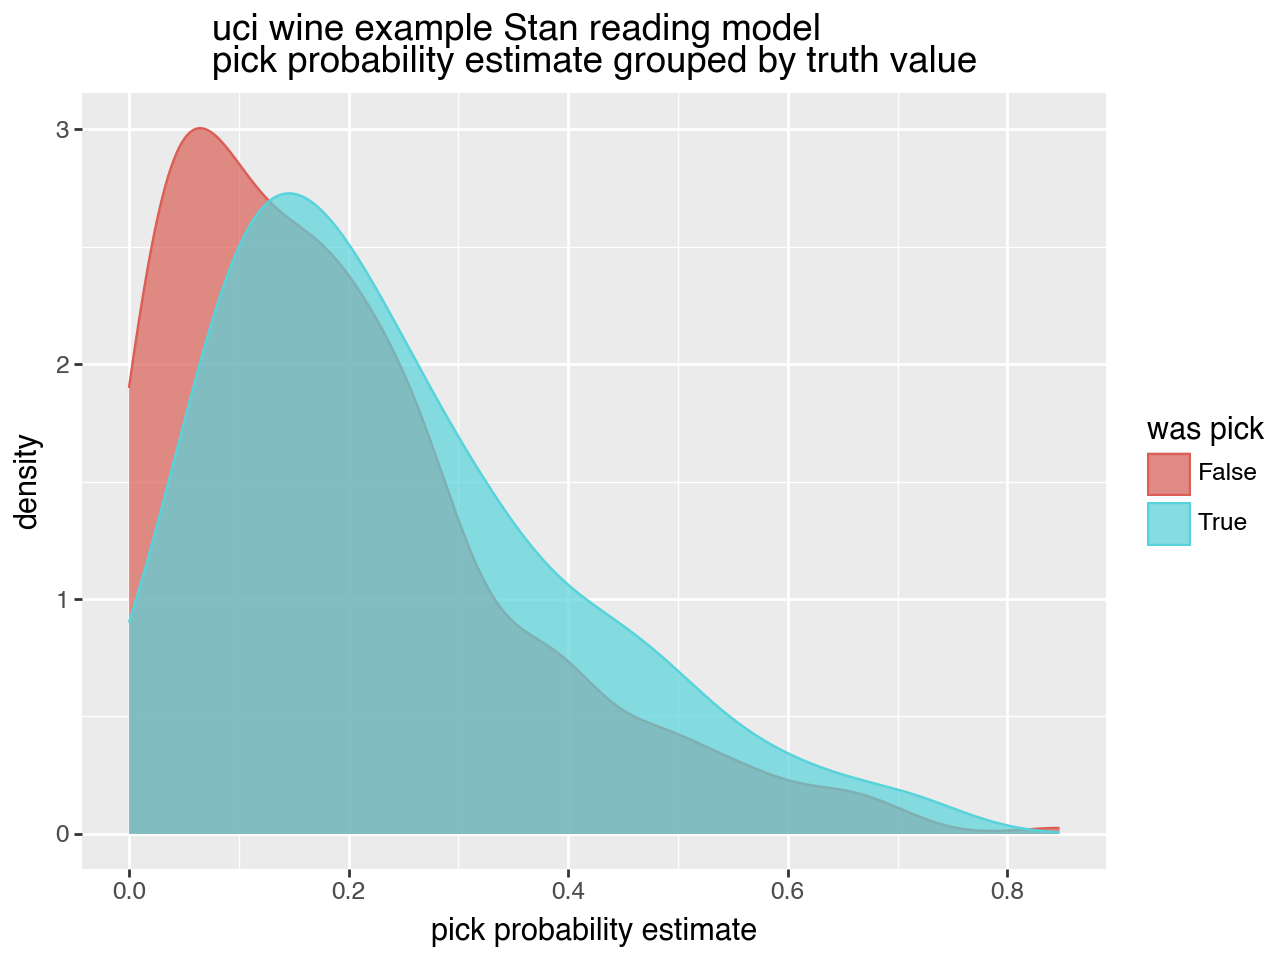

<Figure size 640x480 with 0 Axes>

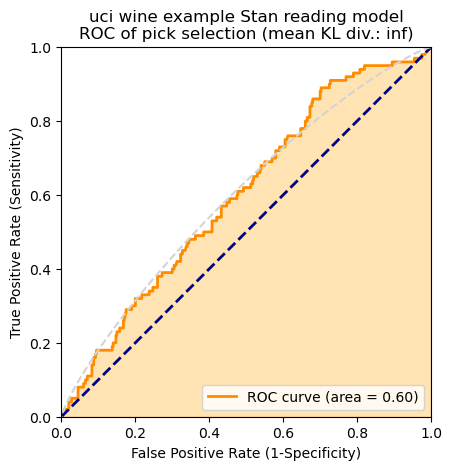

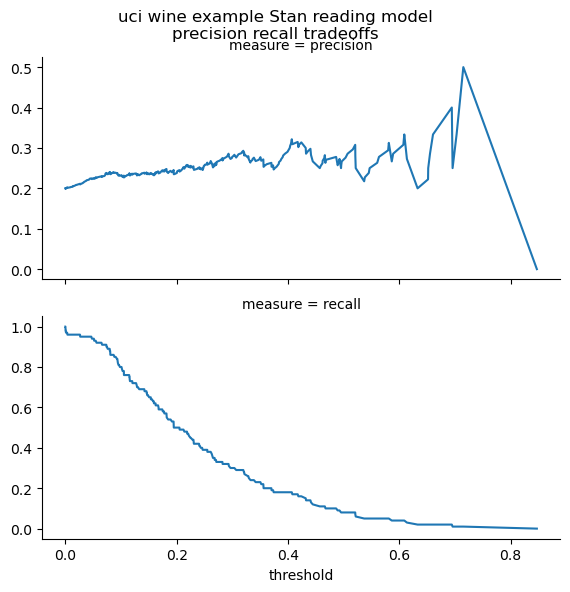

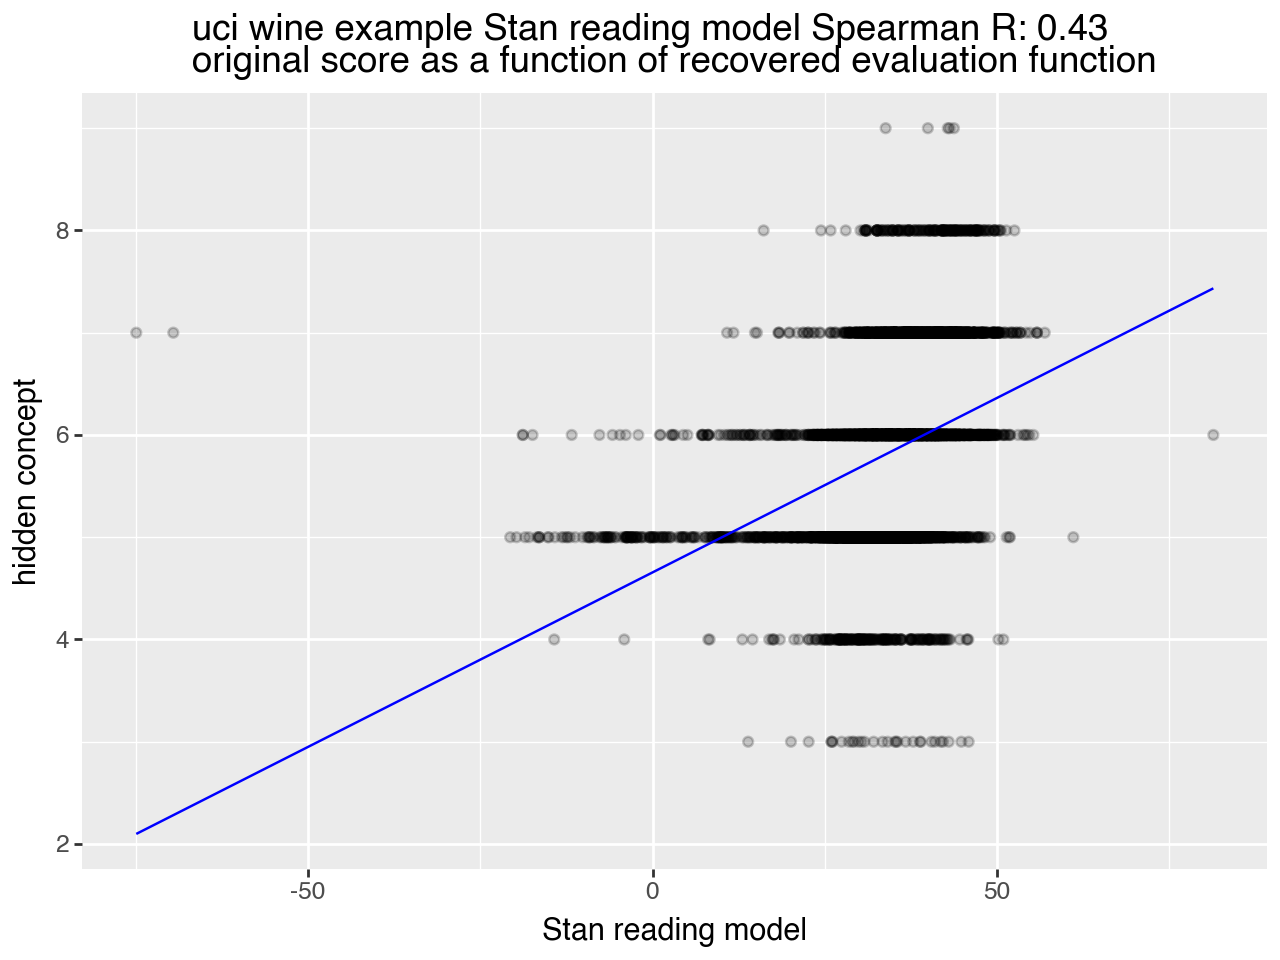

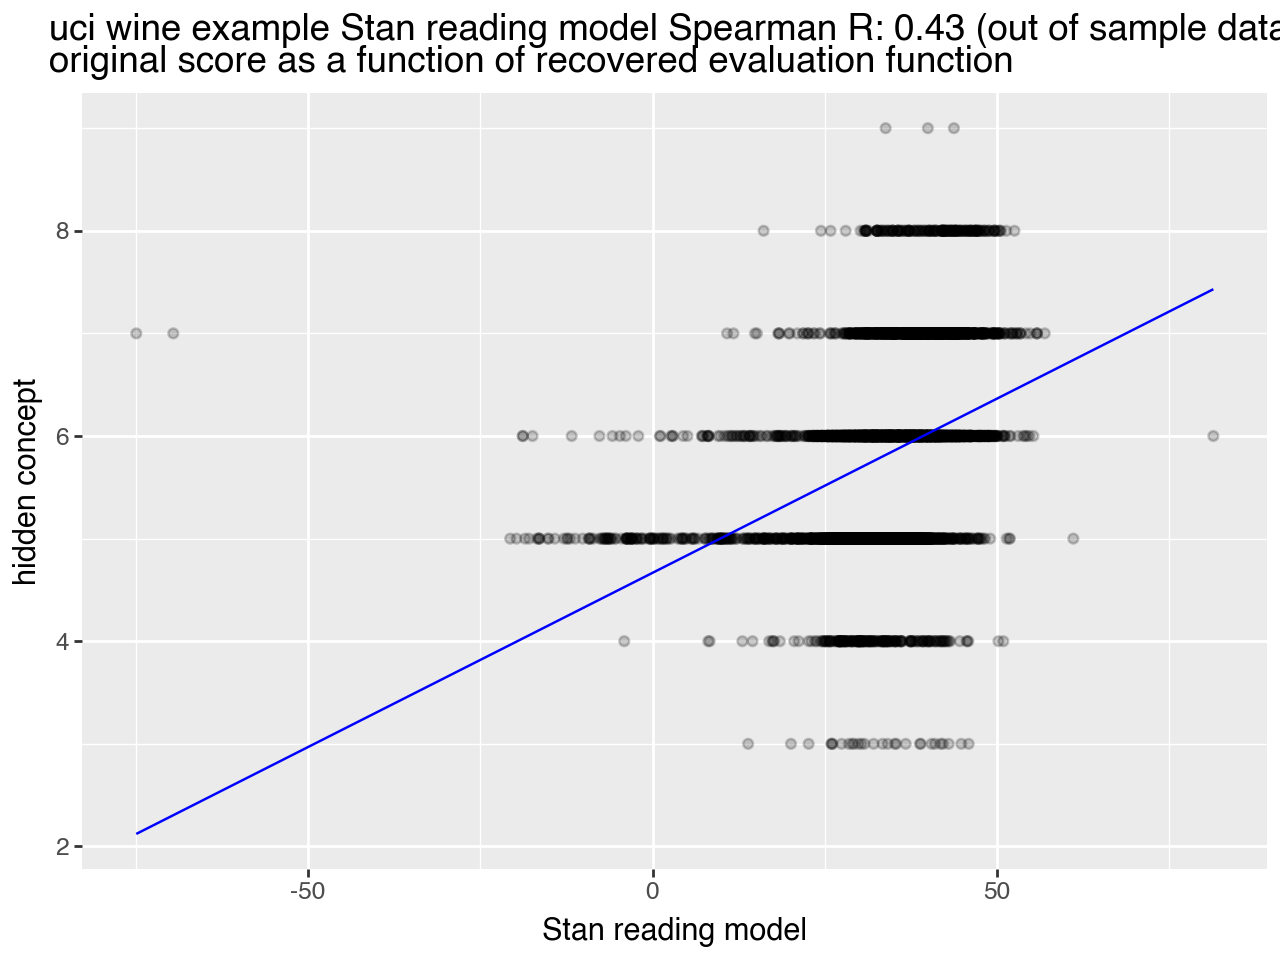

In [27]:
stat_pull = plot_rank_performance(
    model=estimated_beta_Stan,  # estimated coefficients
    model_type='coef',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name="Stan reading model",  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

Try to approximate the Stan model with a classification model with similar error structure.
Consider each pair of panel entries with a different outcome as an observation and try to
build a model that reproduces the observed outcomes.
The extra trick is: repeat the whole data frame negated with the outcomes reverse (so 
we don't define a problem with all positive or all negative outcomes).


In [28]:

feature_names = list(features_frame.columns) + [
    f"position_{sel_i}" for sel_i in range(n_alternatives)
]
enc_frame = []
for row_i in range(observations_train.shape[0]):
    feature_row = observations_train.loc[row_i, :]
    sel_pick = np.argmax(
        feature_row[[f"pick_value_{sel_i}" for sel_i in range(n_alternatives)]]
    )
    for sel_i in range(n_alternatives):
        if sel_i != sel_pick:
            posn_vec = [0] * n_alternatives
            posn_vec[sel_pick] = 1.0
            posn_vec[sel_i] = -1.0
            encoded_row = list(
                    features_frame.loc[feature_row[f"item_id_{sel_pick}"], :]
                    - features_frame.loc[feature_row[f"item_id_{sel_i}"], :]
                ) + posn_vec  
            di = pd.DataFrame({k: [v] for k, v in zip(feature_names, encoded_row)})
            enc_frame.append(di)
enc_frame = pd.concat(enc_frame, ignore_index=True)

In [29]:
classification_model = LogisticRegression(max_iter=10000, solver="newton-cholesky")
classification_model_name = 'logistic'

# classification_model = XgboostClassifier(rng=rng)
# classification_model_name = 'xgboost'

# classification_model = RandomForestClassifier()
# classification_model_name = 'Random Forest'

In [30]:

classification_model.fit(
    X=pd.concat([enc_frame, -enc_frame], ignore_index=True),
    y=[True] * enc_frame.shape[0] + [False] * enc_frame.shape[0],
)

LogisticRegression(max_iter=10000, solver='newton-cholesky')

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2458,False
1,0,1,0.2185,False
2,0,2,0.2078,True
3,0,3,0.1654,False
4,0,4,0.1625,False
5,1,0,0.2282,False
6,1,1,0.2249,True
7,1,2,0.2071,False
8,1,3,0.1798,False
9,1,4,0.1600,False


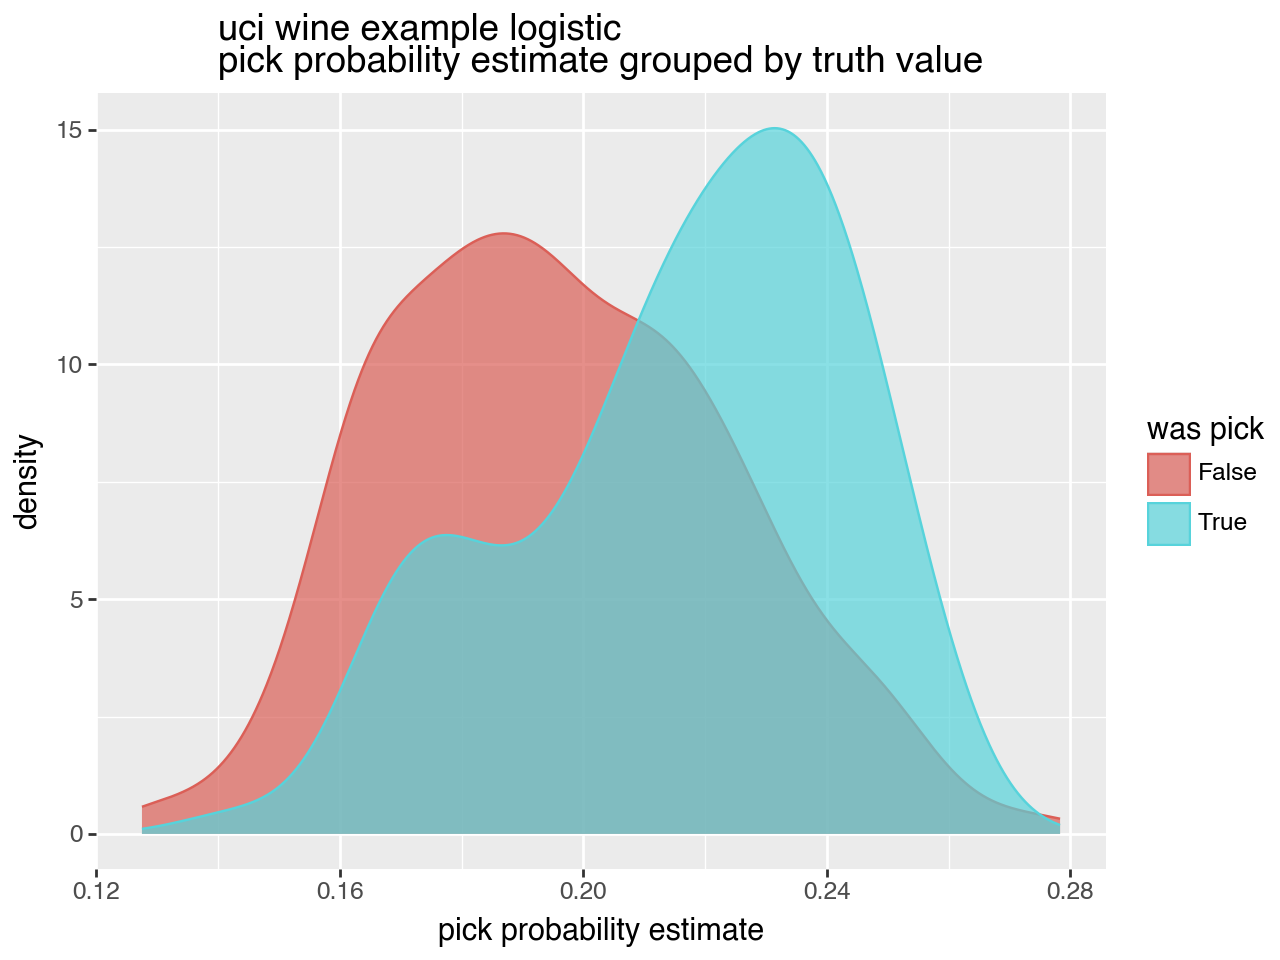

<Figure size 640x480 with 0 Axes>

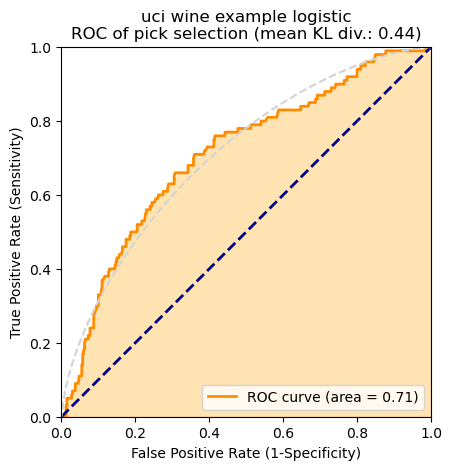

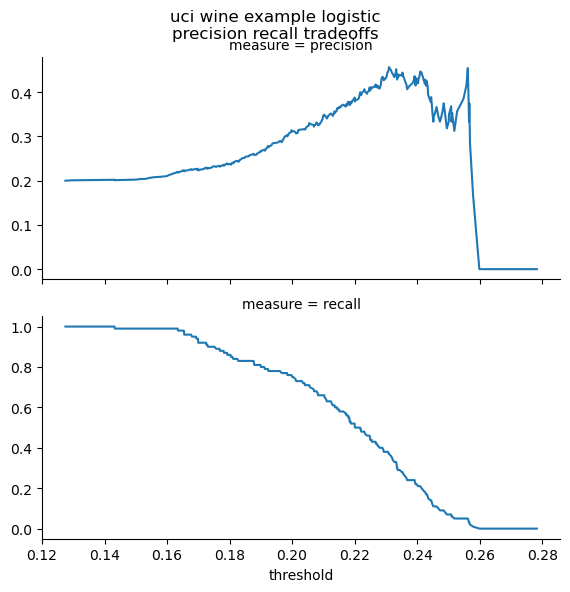

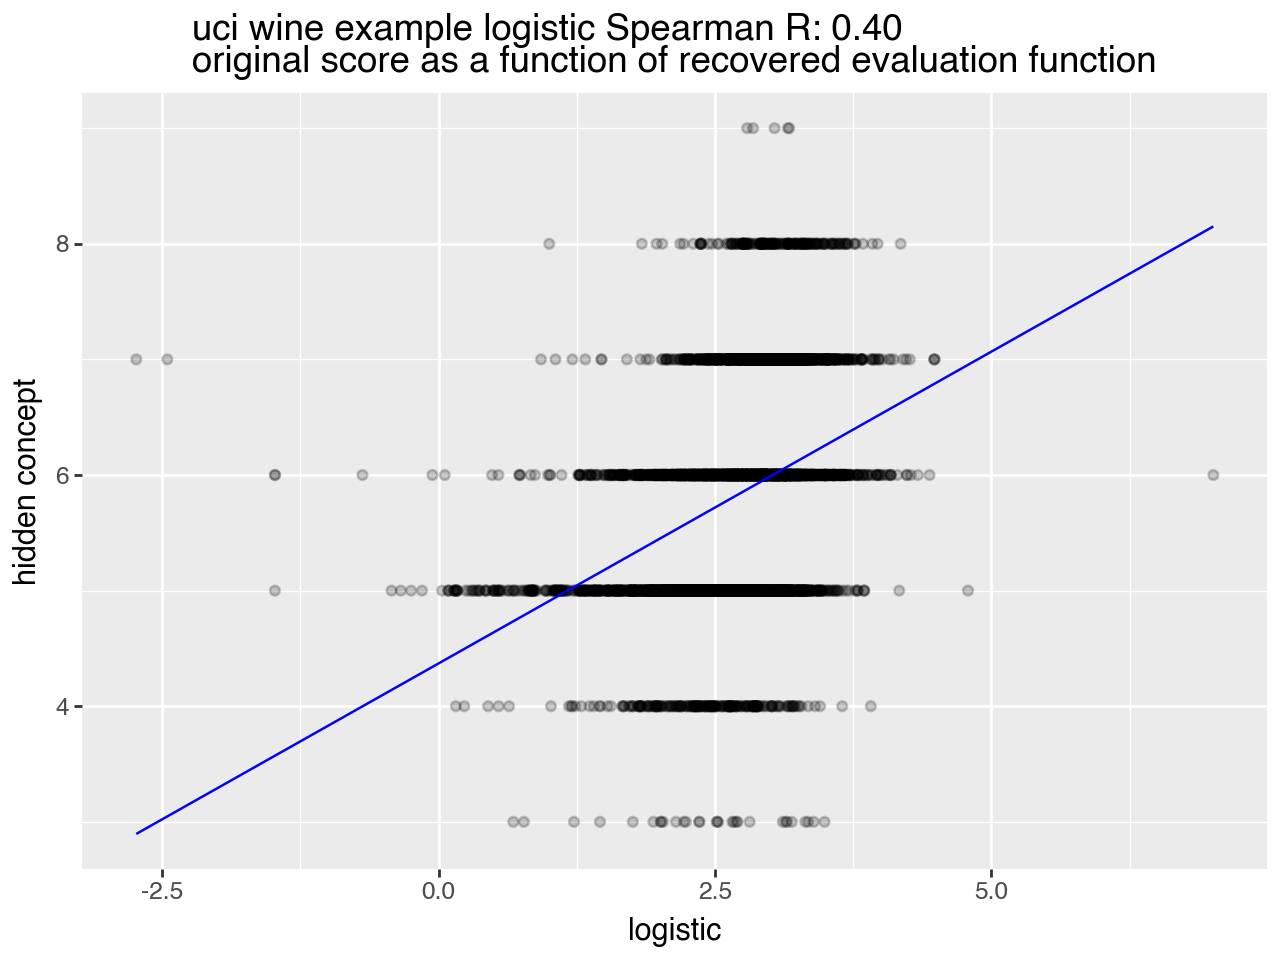

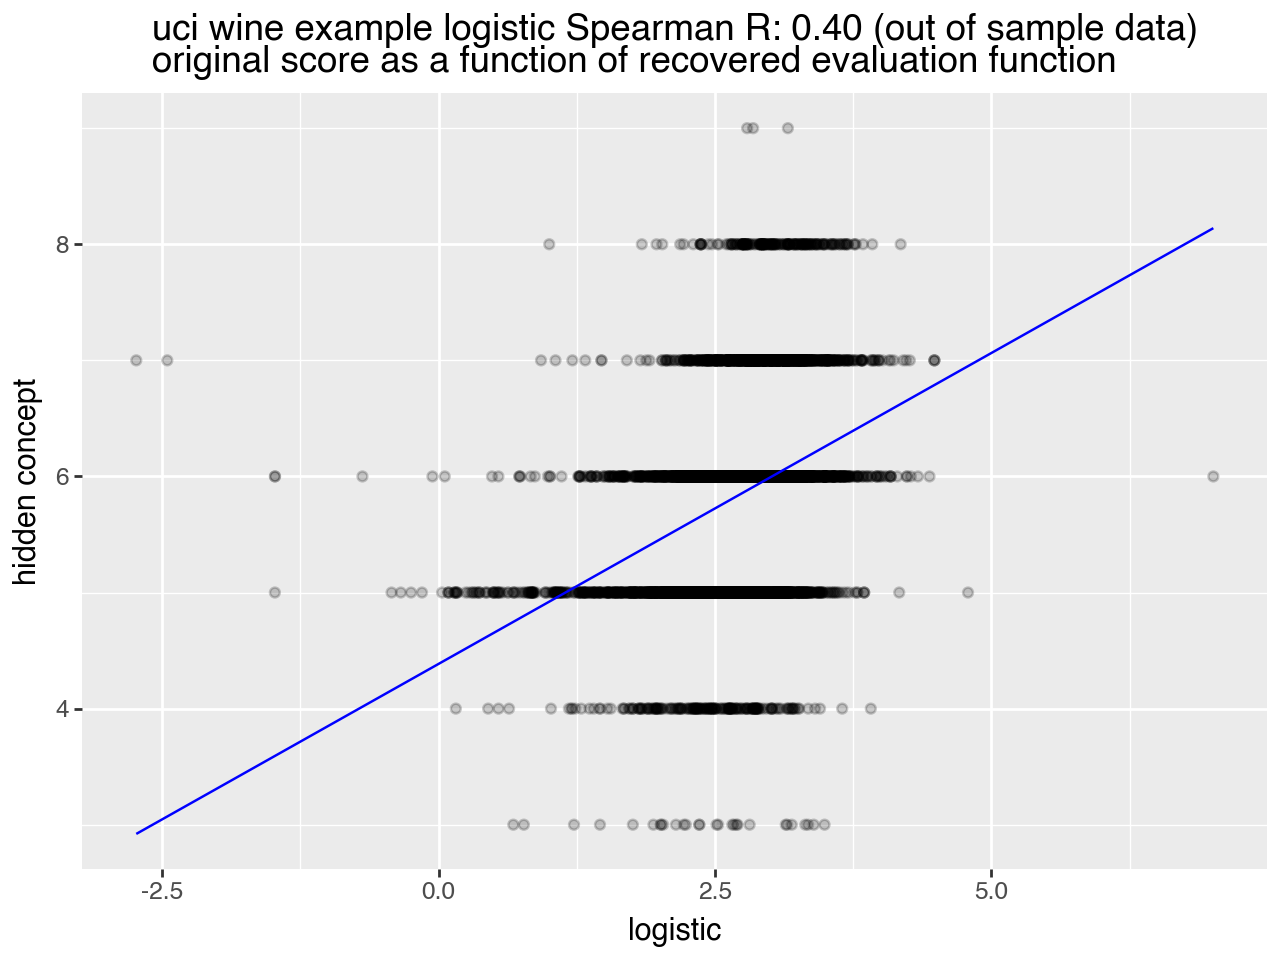

In [31]:
stat_pull = plot_rank_performance(
    model=classification_model,
    model_type='classifier',
    example_name=example_name,  # name of data set
    n_alternatives=n_alternatives,  # size of panels
    features_frame=features_frame,  # features by row id
    observations_train=observations_train,  # training observations layout frame
    observations_test=observations_test,  # evaluation observations layout frame
    estimate_name=classification_model_name,  # display name of estimate
    score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
    rng=rng,  # pseudo random source
    show_plots=do_display,
)
collected_stats.append(stat_pull)

We can compare this to just looking at the scores (not implementable in real world problems).

picks


,row,position,pick probability estimate,was pick
0,0,0,0.2131,False
1,0,1,0.1950,False
2,0,2,0.2107,True
3,0,3,0.1986,False
4,0,4,0.1826,False
5,1,0,0.1811,False
6,1,1,0.2125,True
7,1,2,0.2119,False
8,1,3,0.2082,False
9,1,4,0.1863,False


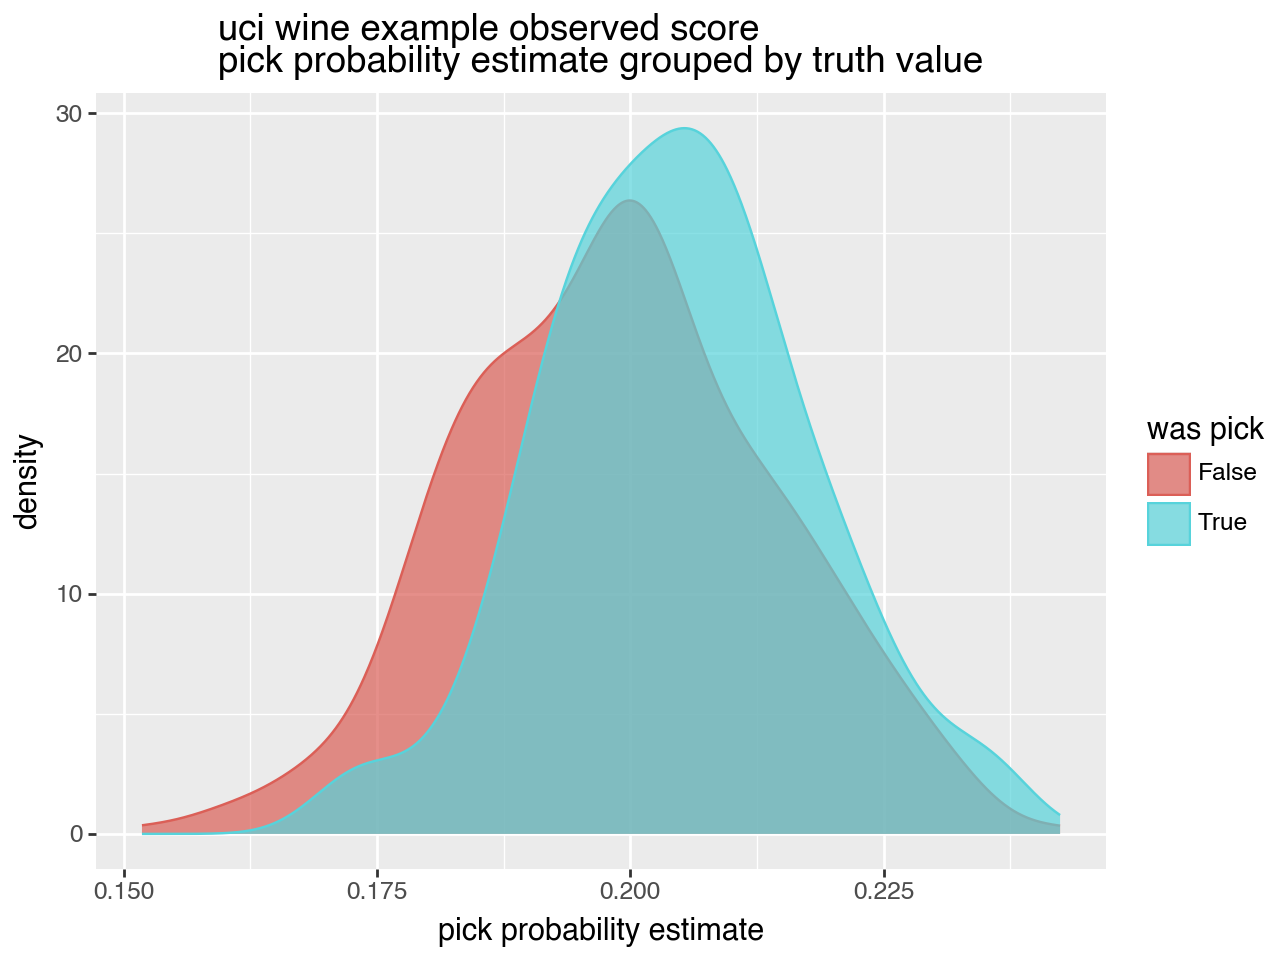

<Figure size 640x480 with 0 Axes>

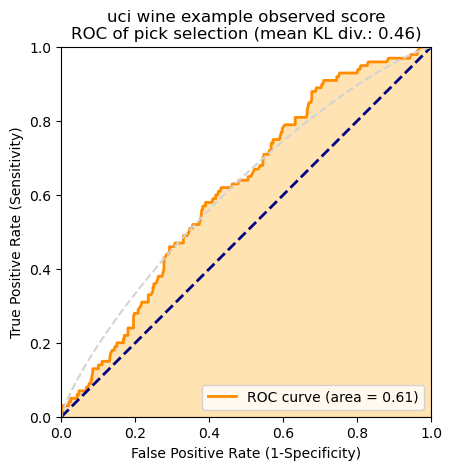

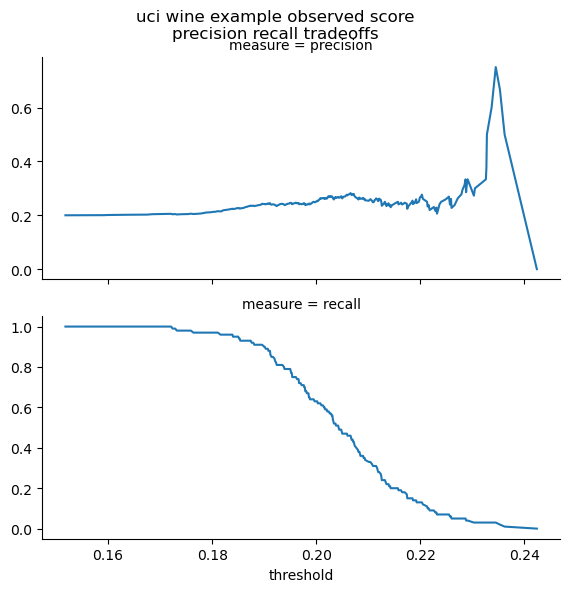

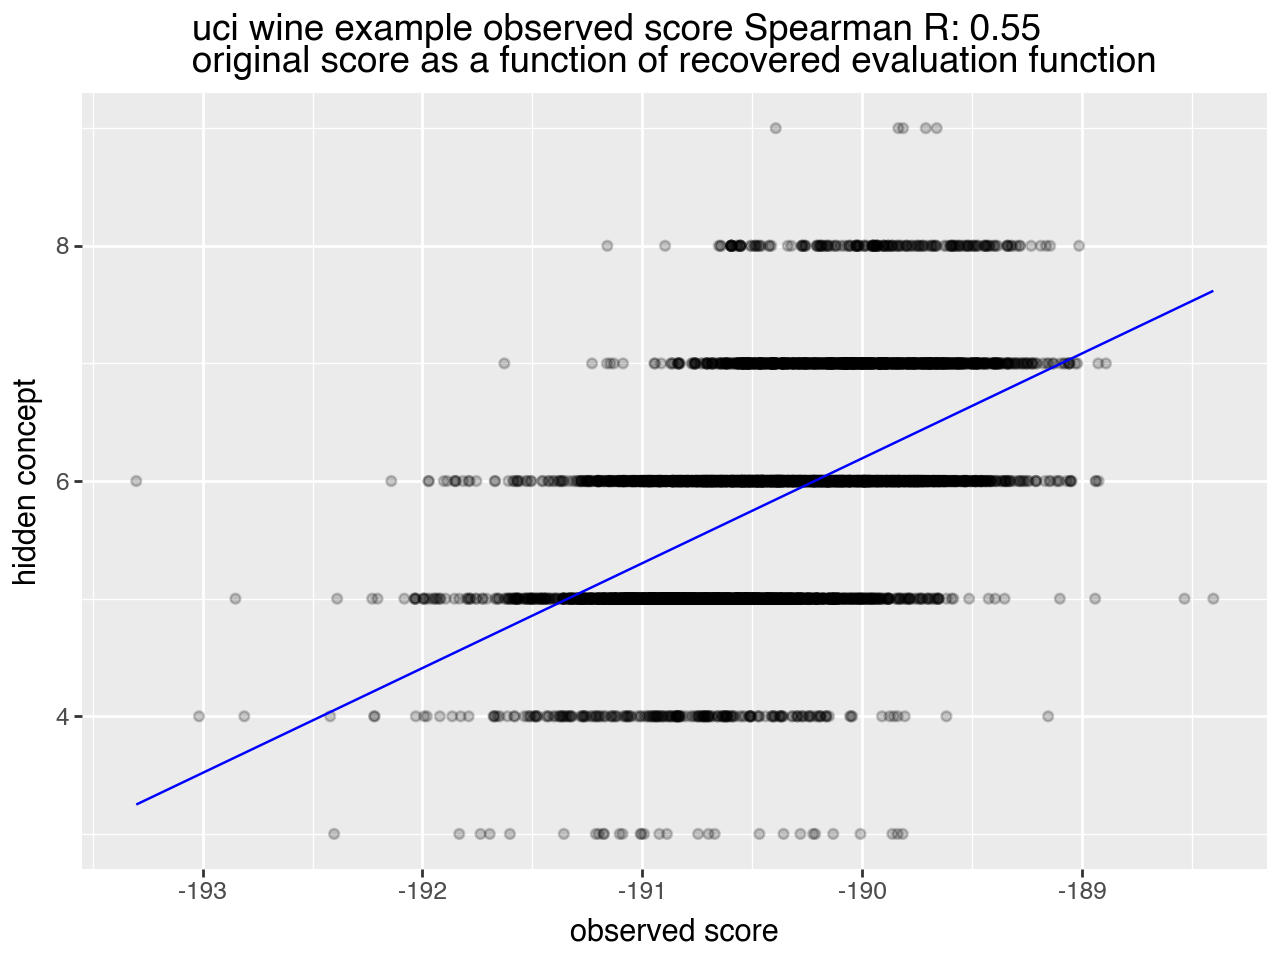

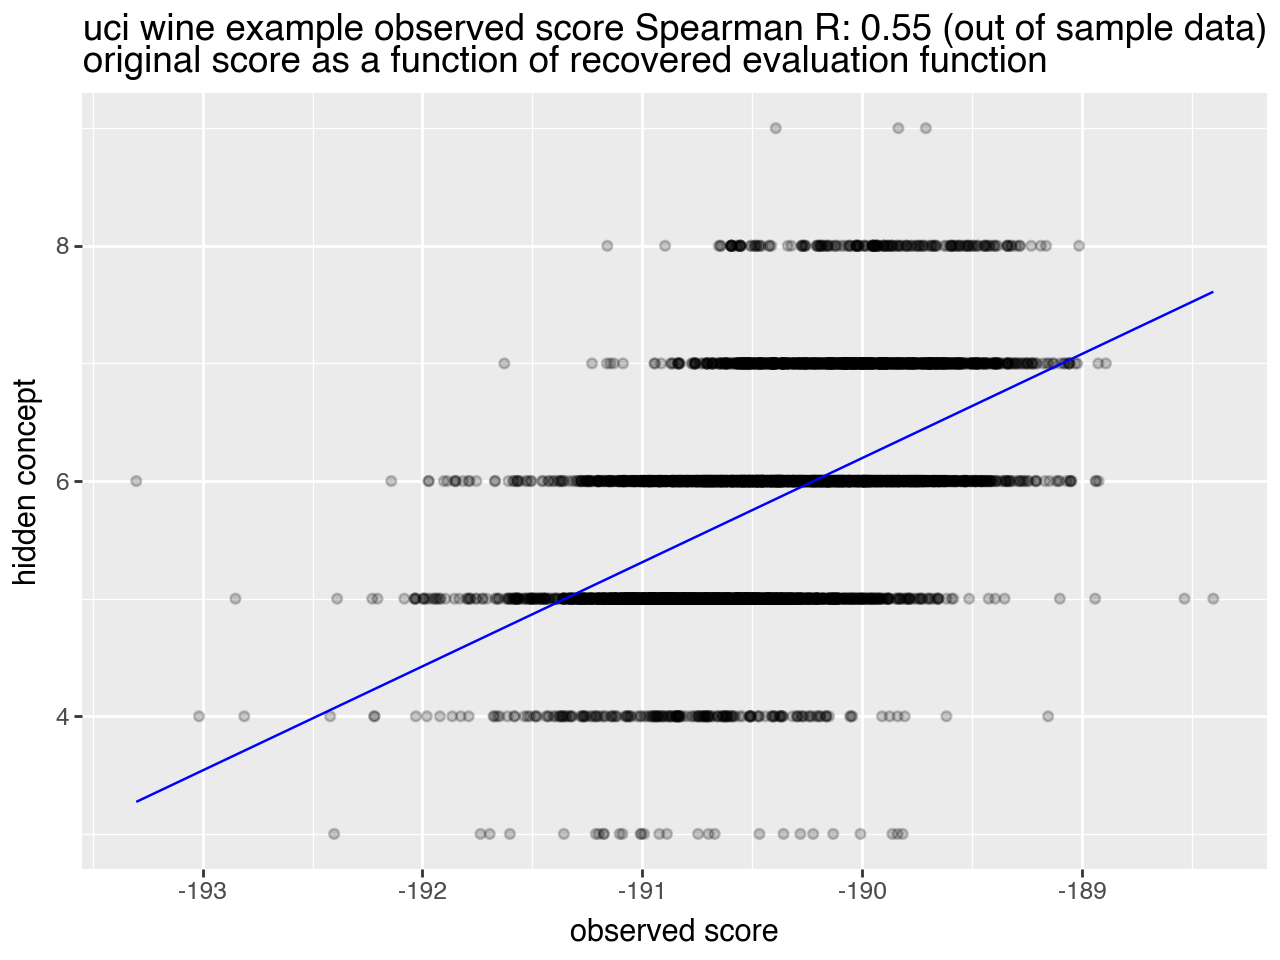

In [32]:
# plug in the perfect model that saw the scores
if know_score and (perfect_coef is not None):
    perfect_pull = plot_rank_performance(
        model=perfect_coef,  # estimated coefficients
        model_type='coef',  # TODO pass regression model directly
        example_name=example_name,  # name of data set
        n_alternatives=n_alternatives,  # size of panels
        features_frame=features_frame,  # features by row id
        observations_train=observations_train,  # training observations layout frame
        observations_test=observations_test,  # evaluation observations layout frame
        estimate_name="observed score",  # display name of estimate
        score_compare_frame=score_compare_frame,  # score comparison frame (altered by call)
        rng=rng,  # pseudo random source
        show_plots=do_display,
    )
    collected_stats.append(perfect_pull)

In [33]:
collected_stats = pd.concat(collected_stats, ignore_index=True)
# collected_stats['perfect_model_SpearmanR'] = perfect_model_SpearmanR

In [34]:
if (result_fname is not None) and (len(result_fname) > 0):
    collected_stats.to_csv(result_fname, index=False)

In [35]:
if do_display:
    display(collected_stats)

,example_name,estimate_name,SpearmanR_all,SpearmanR_test,pick_auc,mean pick KL divergence,training panels,test panels,data_size,test_size
0,uci wine example,Stan reading model,0.432158,0.429921,0.599063,inf,100,100,6497,6013
1,uci wine example,logistic,0.401345,0.399807,0.708388,0.443909,100,100,6497,6013
2,uci wine example,observed score,0.551482,0.549029,0.613613,0.458351,100,100,6497,6013
